# 3.13 丢弃法
除了权重衰减以外，深度学习模型常常使用丢弃法（dropout）来应对过拟合问题。丢弃法有一些不同的变体。本节中提到的丢弃法特指倒置丢弃法（inverted dropout）。

## 3.13.1 方法
回忆一下，多层感知机描述了一个单隐藏层的多层感知机，其中输入个数为4，隐藏单元个数为5，且隐藏单元$h_i(i=1,...,5)$的计算表达式为

$$h_i=\phi(x_1w_{1i}+x_2w_{2i}+x_3w_{3i}+x_4w_{4i}+b_i)$$

当对该隐藏层使用丢弃法时，该层的隐藏单元将有一定概率被丢弃掉。设丢弃概率为$p$，那么有$p$的概率$h_i$会被清零，有$1-p$的概率$h_i$会除以$1-p$来拉伸。丢弃概率是丢弃法的超参数，具体来说，设随机变量$\xi_i$为0和1的概率分别为$p$和$1-p$。使用丢弃法时计算新的隐藏单元$h_i'$

$$h_i'=\frac{\xi_i}{1-p}h_i$$

由于$E(\xi_i)=1-p$，因此

$$E(h_i')=\frac{E(\xi_i)}{1-p}h_i=h_i$$

即**丢弃法不改变其输入的期望值**，对隐藏层使用丢弃法，一种可能的结果如下图所示，其中$h_2$和$h_5$被清零。这时输出值的计算不再依赖$h_2$和$h_5$，在反向传播时，与这两个隐藏单元相关的权重的梯度均为0。由于在训练中隐藏层神经元的丢弃是随机的，即$h_1,…,h_5$都有可能被清零，输出层的计算无法过度依赖$h_1,…,h_5$中的任一个，从而在训练模型时起到正则化的作用，并可以用来应对过拟合。在测试模型时，我们为了拿到更加确定性的结果，一般不使用丢弃法。
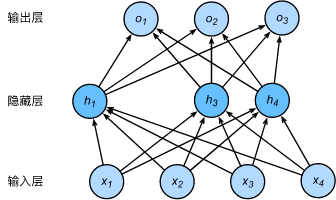

## 3.13.2 从零开始实现
下面的 dropout 函数将以 drop_prob 的概率丢弃 X 中的元素

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import d2lzh_pytorch as d2l

In [2]:
def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    # 这种情况下把全部元素都丢弃
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()
    
    return mask * X / keep_prob

测试一下 dropout 函数，其中丢弃概率分别为0、0.5和1

In [3]:
X = torch.arange(16).view(2, 8)
dropout(X, 0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [4]:
dropout(X, 0.5)

tensor([[ 0.,  0.,  4.,  0.,  0.,  0., 12., 14.],
        [16.,  0.,  0., 22., 24.,  0.,  0.,  0.]])

In [5]:
dropout(X, 1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

### 3.13.2.1 定义模型参数
依然使用Fashion-MNIST数据集。我们将定义一个包含两个隐藏层的多层感知机，其中两个隐藏层的输出个数都是256。

In [6]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

"""
X(batch_size, 784)
W1(784,256) b1(256,1) W2(256,256) b2(256,1) W3(256,10) b3(10, 1)
"""

W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

### 3.13.2.2 定义模型
下面定义的模型将全连接层和激活函数ReLU串起来，并对每个激活函数的输出使用丢弃法。我们可以分别设置各个层的丢弃概率。通常的建议是把靠近输入层的丢弃概率设得小一点。在这个实验中，我们把第一个隐藏层的丢弃概率设为 0.2，把第二个隐藏层的丢弃概率设为 0.5。我们可以通过参数 is_training 来判断运行模式为训练还是测试，并只需在训练模式下使用丢弃法。

In [7]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training:  # 只在训练模型时使用丢弃法
        H1 = dropout(H1, drop_prob1)  # 在第一层全连接后添加丢弃层
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)  # 在第二层全连接后添加丢弃层
    return torch.matmul(H2, W3) + b3

我们在对模型评估的时候不应该进行丢弃，所以我们修改一下 d2lzh_pytorch 中的 evaluate_accuracy 函数:

In [8]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module): # 如果使用Pytorch自带的模型
            net.eval() # 评估模式，这会关闭dropout
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train() # 改回训练模式
        else: # 如果使用自定义的模型
            if ('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                # 将is_training设置为False
                acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
            else:
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

### 3.13.2.3 训练和测试模型

In [9]:
num_epochs, lr, batch_size = 5, 100.0, 256
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0046, train acc 0.542, test acc 0.741
epoch 2, loss 0.0023, train acc 0.782, test acc 0.734
epoch 3, loss 0.0020, train acc 0.820, test acc 0.827
epoch 4, loss 0.0017, train acc 0.838, test acc 0.802
epoch 5, loss 0.0016, train acc 0.848, test acc 0.846


## 3.13.3 简洁实现
在PyTorch中，我们只需要在全连接层后添加Dropout层并指定丢弃概率。在训练模型时，Dropout层将以指定的丢弃概率随机丢弃上一层的输出元素；在测试模型时（即model.eval()后），Dropout层并不发挥作用。

In [10]:
net = nn.Sequential(
    d2l.FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens1),
    nn.ReLU(),
    nn.Dropout(drop_prob1),
    nn.Linear(num_hiddens1, num_hiddens2),
    nn.ReLU(),
    nn.Dropout(drop_prob2),
    nn.Linear(num_hiddens2, 10)
)

for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [11]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0045, train acc 0.558, test acc 0.709
epoch 2, loss 0.0023, train acc 0.786, test acc 0.742
epoch 3, loss 0.0019, train acc 0.821, test acc 0.808
epoch 4, loss 0.0017, train acc 0.837, test acc 0.805
epoch 5, loss 0.0016, train acc 0.848, test acc 0.842


# 小结
* 我们可以通过使用丢弃法应对过拟合。
* 丢弃法只在训练模型时使用。